In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

AR(1) plot

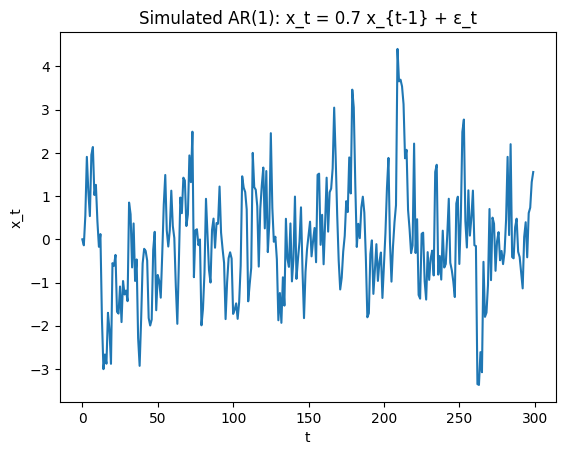

In [2]:
np.random.seed(42)

T = 300

phi = 0.7
sigma = 1.0
eps = np.random.normal(0, sigma, size=T)
x_ar1 = np.zeros(T)
for t in range(1, T):
    x_ar1[t] = phi * x_ar1[t-1] + eps[t]

plt.figure()
plt.plot(x_ar1)
plt.title("Simulated AR(1): x_t = 0.7 x_{t-1} + ε_t")
plt.xlabel("t")
plt.ylabel("x_t")
plt.show()


AR(2) plot

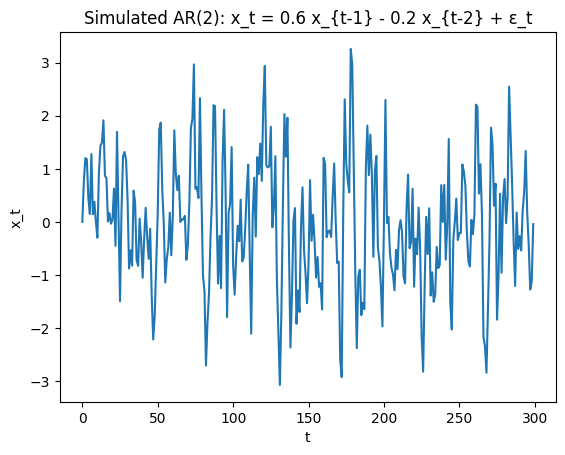

In [3]:
phi1, phi2 = 0.6, -0.2  # stationary
sigma2 = 1.0
eps2 = np.random.normal(0, sigma2, size=T)
x_ar2 = np.zeros(T)
x_ar2[1] = np.random.normal()  # seed second value
for t in range(2, T):
    x_ar2[t] = phi1 * x_ar2[t-1] + phi2 * x_ar2[t-2] + eps2[t]

plt.figure()
plt.plot(x_ar2)
plt.title("Simulated AR(2): x_t = 0.6 x_{t-1} - 0.2 x_{t-2} + ε_t")
plt.xlabel("t")
plt.ylabel("x_t")
plt.show()


VAR(1) plots

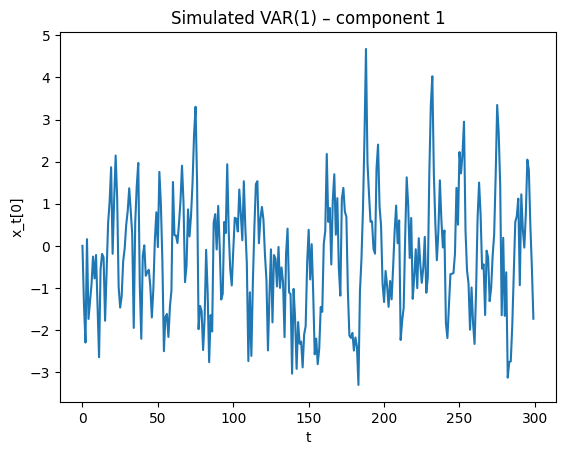

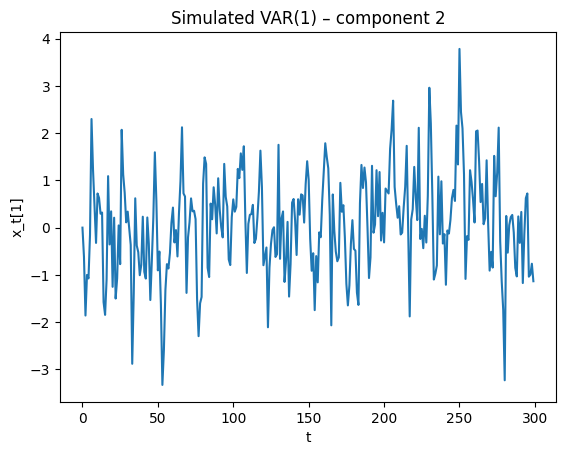

In [4]:
A = np.array([[0.6, 0.2],
              [-0.1, 0.5]])
cov = np.array([[1.0, 0.3],
                [0.3, 0.8]])
eps_var = np.random.multivariate_normal(np.zeros(2), cov, size=T)
x_var = np.zeros((T, 2))
for t in range(1, T):
    x_var[t] = A @ x_var[t-1] + eps_var[t]

plt.figure()
plt.plot(x_var[:, 0])
plt.title("Simulated VAR(1) – component 1")
plt.xlabel("t")
plt.ylabel("x_t[0]")
plt.show()

plt.figure()
plt.plot(x_var[:, 1])
plt.title("Simulated VAR(1) – component 2")
plt.xlabel("t")
plt.ylabel("x_t[1]")
plt.show()


Bayesian inference on some simple processes

In [5]:
import pymc as pm
import arviz as az
import pytensor.tensor as at

In [6]:
phi = 0.7
sigma = 1.0
eps = np.random.normal(0, sigma, size=T)
x1 = np.zeros(T)
for t in range(1, T):
    x1[t] = phi * x1[t-1] + eps[t]

Output()

Output()

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'phi'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

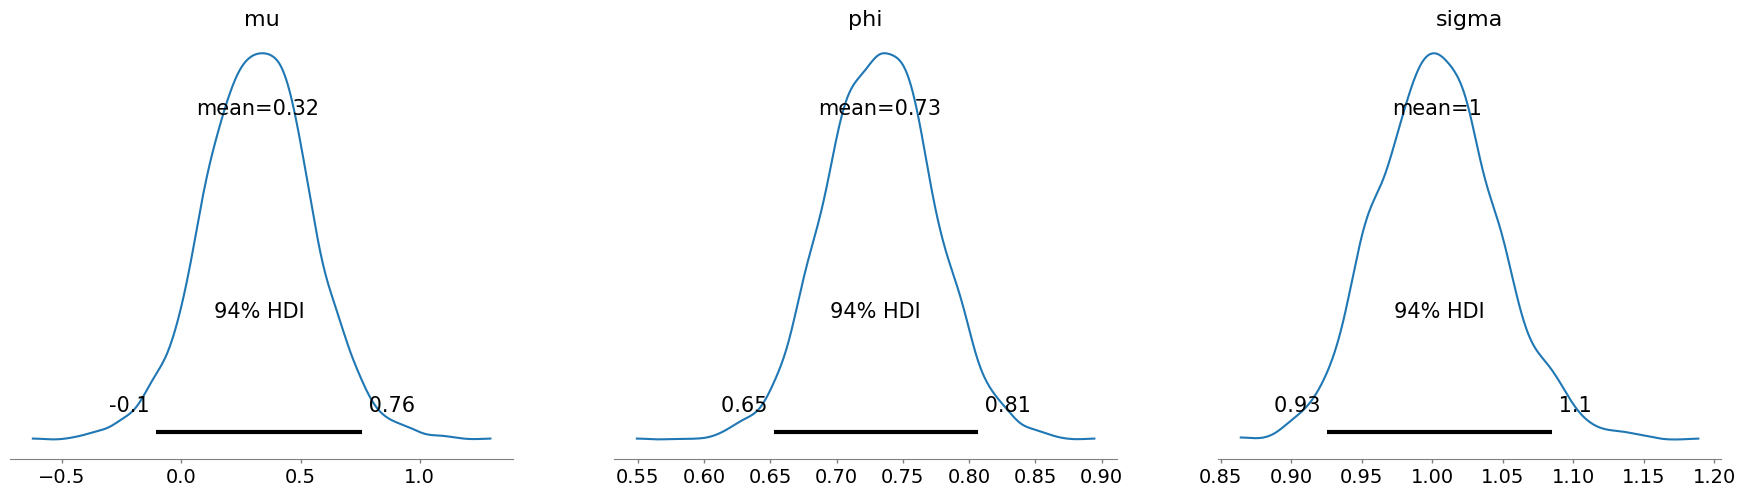

In [7]:
y = x1  #  observed series

with pm.Model() as ar1:
    phi   = pm.Normal("phi", 0, 0.5)
    sigma = pm.HalfNormal("sigma", 1.0)
    mu    = pm.Normal("mu", 0, 5)

    mean = mu + phi * (y[:-1] - mu)
    pm.Normal("y_obs", mu=mean, sigma=sigma, observed=y[1:])

    idata = pm.sample(tune=1000, draws=1000, chains=4, target_accept=0.9)
    post = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

az.summary(idata, var_names=["mu","phi","sigma"])
az.plot_posterior(idata, var_names=["mu","phi","sigma"])

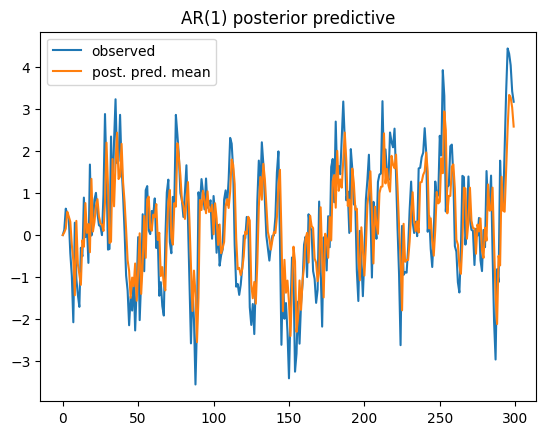

In [8]:
yhat = post.posterior_predictive["y_obs"].stack(s=("chain","draw")).values
yhat_mean = yhat.mean(axis=-1)

plt.figure()
plt.plot(y, label="observed")
plt.plot(np.r_[y[0], yhat_mean], label="post. pred. mean")  # align length
plt.legend(); plt.title("AR(1) posterior predictive"); plt.show()

In [9]:
np.random.seed(7)
T = 300
A_true = np.array([[0.6, 0.2],
                   [-0.1, 0.5]])
cov_true = np.array([[1.0, 0.3],
                     [0.3, 0.8]])

eps = np.random.multivariate_normal(np.zeros(2), cov_true, size=T)
Y = np.zeros((T, 2))
for t in range(1, T):
    Y[t] = A_true @ Y[t-1] + eps[t]
Ylag, Yt = Y[:-1], Y[1:]


In [10]:

with pm.Model() as var1:
    A = pm.Normal("A", 0, 0.5, shape=(2,2))

    # get packed cholesky of cov
    out = pm.LKJCholeskyCov(
        "L_packed",
        n=2,
        eta=2.0,
        sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=False,
    )
    L_packed = out[0] if isinstance(out, tuple) else out
    L = pm.expand_packed_triangular(2, L_packed)

    mean = pm.math.dot(Ylag, A.T)  # (T-1,2)
    pm.MvNormal("Y_obs", mu=mean, chol=L, observed=Yt)

    idata = pm.sample(tune=1000, draws=1000, chains=2, target_accept=0.9)
    ppc   = pm.sample_posterior_predictive(idata, var_names=["Y_obs"], extend_inferencedata=True)

Output()

/usr/local/lib/python3.12/dist-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

Output()

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]  0.573  0.045   0.487    0.654      0.001    0.001    2136.0   
A[0, 1]  0.205  0.060   0.091    0.316      0.001    0.001    2491.0   
A[1, 0] -0.110  0.042  -0.191   -0.032      0.001    0.001    2770.0   
A[1, 1]  0.439  0.054   0.338    0.541      0.001    0.001    2220.0   

         ess_tail  r_hat  
A[0, 0]    1555.0    1.0  
A[0, 1]    1416.0    1.0  
A[1, 0]    1640.0    1.0  
A[1, 1]    1574.0    1.0  


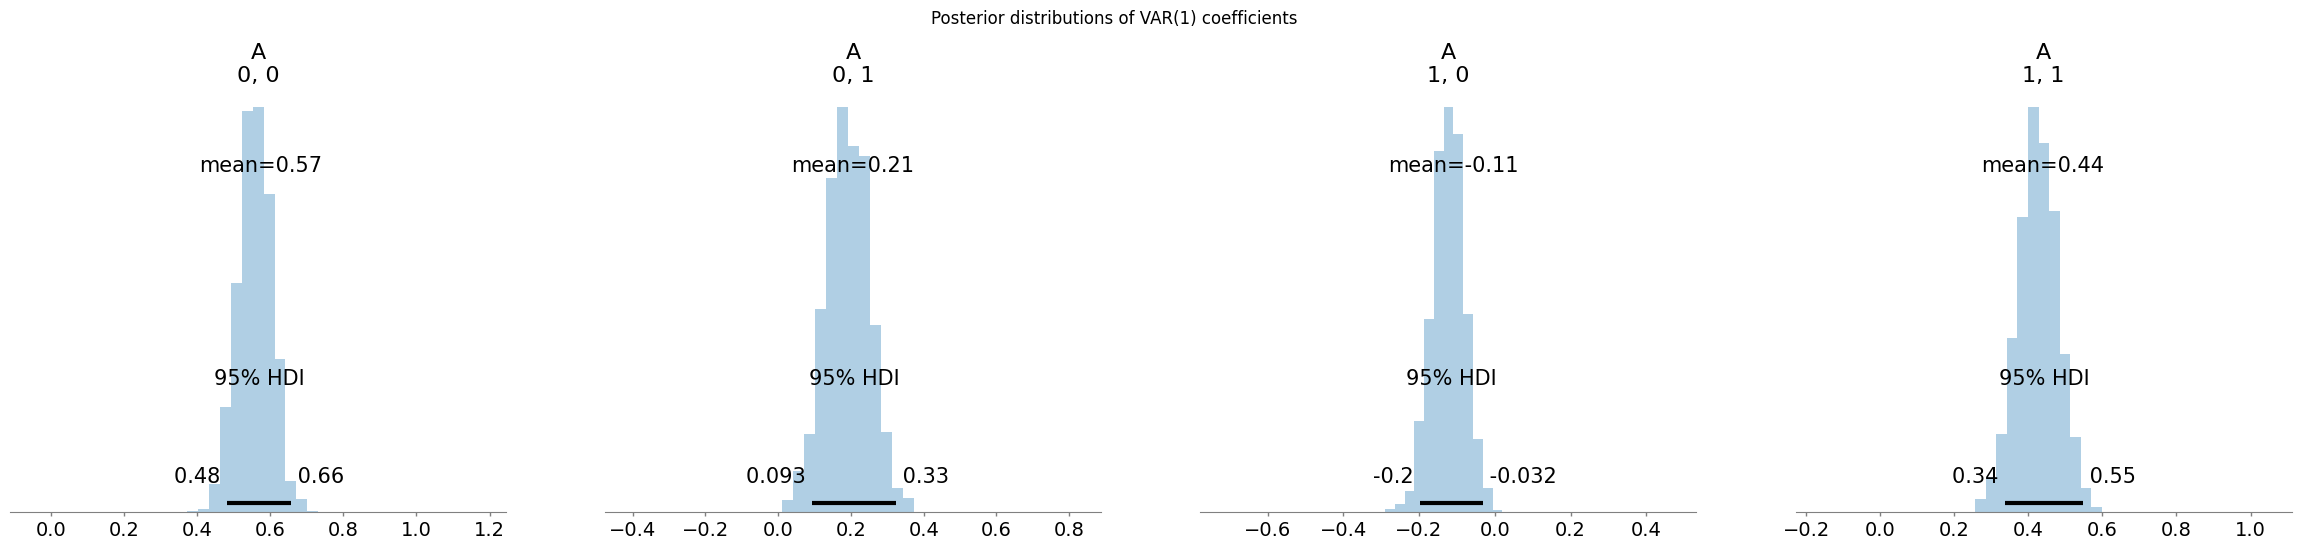

In [11]:
print(az.summary(idata, var_names=["A"]).round(3))
az.plot_posterior(idata, var_names=["A"], kind="hist", hdi_prob=0.95)
plt.suptitle("Posterior distributions of VAR(1) coefficients", y=1.02)
plt.show()

In [12]:
import os, glob

print(os.getcwd())               # should be /content
print(os.listdir("/content"))    # list files you actually have
print(glob.glob("/content/*.ipynb"))

/content
['.config', 'sample_data']
[]
